# Major Command Calculator

### Rules of Dice Rolls
During the assault phase of a player's turn, they may choose to attack a neighboring enemy's (or teammate's) territory.  Attacks can only happen along borders. In a given assualt, let's assume there is an attacker with $M$ troops attacking and a defender with $N$ troops defending. (Note that at least 2 troops are needed to attack). 

To decide the outcome of the single assault, the attacker and defender both roll dice. The attacker gets ${\rm min}(3,M-1)$ dice to roll, while the defender gets ${\rm min}(2,N)$.  After the dice are rolled, the attacker's highest dice roll is matched up against the defender's highest, and if applicable, the attacker's second highest with the defender's second die. For each dice match-up, if the attacker's die is higher than the defender's, the defender loses a troop.  If the attacker's die is equal to or lower than the defender's, the attacker loses a troop.  Let's go through an example in gory detail:

Suppose the attacker has 4 troops and the defender has 2.  Using the formulae above, the attacker gets 3 dice and the defender gets 2.  Let's say the attacker rolls (6,3,1) and the defender rolls (4,3).  We start by matching up the highest rolls: The attacker's 6 versus the defender's 4. Since 6 is greater than 4, the defender loses a troop. Now we match up the next highest dice: attacker's 3 versus defender's 3.  Tie always goes to the defender, so the attacker loses a troop.  This ends the assault and the attacker is left with 3 troops and the defender, 1.  

Now suppose the attacker attacks again. The attacker gets 2 dice, and the defender gets 1.  If the attacker gets a higher roll on either of their dice than the defender's one, the defender is vanquished.  If not, the attacker loses a troop.  Let's suppose the attacker loses a troop and is now down to 2 troops.  If they attack again, it's one die versus one die and if the attacker gets a higher roll, they win.  Otherwise the attacker loses a troop and is down to one!

Okay, that's the theory.  Now it's time to actually calculate!  We'll start by defining some useful stuff:

In [44]:
# imports
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Create a Region class that essentially holds troop number
class Region:
    def __init__(self, N):
        """Number of troops is N.  Must be integer"""
        self.N = N
        
    def loss(self):
        self.N = self.N - 1
    
    @property
    def dead(self):
        return self.N == 0 

# function to simulate a dice roll and subsequent troop losses
def assault(attacker,defender):
    
    # figure out number of dice for attacker and defender
    ndice1,ndice2 = min(3,attacker.N-1), min(2,defender.N)
    
    # roll the dice and sort them from largest to smallest
    rolls1 = np.sort(np.random.randint(1,7,size=ndice1))[::-1]
    rolls2 = np.sort(np.random.randint(1,7,size=ndice2))[::-1]
    for d in range(min(ndice1,ndice2)):
        if rolls1[d] > rolls2[d]:
            defender.loss()
        else:
            attacker.loss()
        if ((attacker.N == 1) or (defender.N == 0)):
            return True
    return False

def blitz(attacker,defender,troops_left = 3):
    stop = False
    while ((attacker.N > troops_left) and (stop==False)):
        stop = assault(attacker,defender)
        
            
def p_win_whole_battle(M,N,troops_left=3):
    n_exp = 1000 # number of Monte Carlo iterations
    nwins = 0
    for i in range(n_exp):
        attacker = Region(M)
        defender = Region(N)
        blitz(attacker,defender,troops_left=troops_left)
        if defender.dead:
            nwins = nwins +1
    return float(nwins)/n_exp

With these definitions we can calculate various probabilities by "Monte Carlo" -- i.e. we run many many simulations of assualts and look at how many of simulations give a certain outcome.  Let's start with a simple case.  If an attacker with $M$ troops blitzes $3$ troops, what's the probability the defender is eliminated? Let's assume the attacker does a "full blitz", i.e. they are willing to deplete down to 1 troop. First let's simulate this assault a bunch of times:

In [29]:
n_exp = 1000 # number of Monte Carlo iterations
troops_left = 1
N = 3
Ms = range(3,10)
attackers_left,defenders_left = np.zeros([n_exp,len(Ms)]), np.zeros([n_exp,len(Ms)])
for m,M in enumerate(Ms):
    for i in range(n_exp):
        attacker = Region(M)
        defender = Region(N)
        blitz(attacker,defender,troops_left=1)
        attackers_left[i,m] = attacker.N
        defenders_left[i,m] = defender.N
        

Now plot the probability of having different numbers of attackers and defenders left

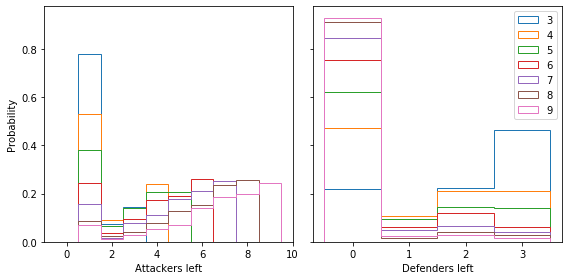

In [31]:
fig,ax = plt.subplots(1,2,figsize=(8,4),sharey=True)
for m,M in enumerate(Ms):
    ax[0].hist(attackers_left[:,m],bins=np.arange(-1,10)+0.5,label=str(M),histtype='step',density=True)
    ax[1].hist(defenders_left[:,m],bins=np.arange(-1,4)+0.5,label=str(M),histtype='step',density=True)
ax[1].legend(loc=1)
ax[0].set_xlabel('Attackers left')
ax[1].set_xlabel('Defenders left')
ax[0].set_ylabel('Probability')
fig.tight_layout()


Now let's make a whole grid and see the win probabilities of assaulting, i.e. recreate the table on [this page](https://www.majorcommand.com/wiki/Nature_of_Dice_Luck_and_Streaks)

In [50]:
Ms = np.arange(2,10)
Ns = np.arange(1,10)
pwins = np.zeros([len(Ms),len(Ns)])
for m,M in enumerate(Ms):
    for n,N in enumerate(Ns):
        pwins[m,n] = p_win_whole_battle(M,N,troops_left=1)

In [51]:
import pandas as pd
pd.DataFrame(pwins.T, columns=Ms-1, index=Ns) # use Ms-1 here to match definitions in the MajorCommand instructions


,1,2,3,4,5,6,7,8
1,0.432,0.762,0.917,0.969,0.986,0.997,0.997,1.000
2,0.112,0.395,0.661,0.779,0.876,0.920,0.967,0.981
3,0.022,0.228,0.503,0.648,0.764,0.862,0.890,0.942
4,0.011,0.084,0.313,0.447,0.650,0.771,0.836,0.900
5,0.003,0.054,0.207,0.316,0.510,0.653,0.722,0.822
6,0.000,0.018,0.144,0.262,0.389,0.543,0.648,0.749
7,0.000,0.007,0.067,0.195,0.286,0.403,0.552,0.661
8,0.000,0.005,0.063,0.120,0.218,0.317,0.440,0.565
9,0.000,0.001,0.042,0.088,0.175,0.268,0.347,0.472
